<a href="https://colab.research.google.com/github/yuchenhe-xai/yccolab/blob/main/241029_exp_better_user_production_fer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
%load_ext autoreload
%autoreload 2
import os, sys, json, yaml
!pip install polars --index-url https://pypi.org/simple
# !pip install -U flax treescope
# !pip install einops
# !pip install optax
# !pip install grpcio
# !pip install toml
# !pip install serde
# !pip install serde-ext
# !pip install fire
# !pip install openai
# !pip install -U serde

sys.path.append(os.path.expanduser('~/xai/train/'))

# !pip install -U dm-haiku # install the missing 'haiku' module

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
     |████████████████████████████████| 34.1 MB 4.0 MB/s            


In [ ]:
import inspect

# sys.path.append(os.path.expanduser('~/xai/train/'))

import xlm
import xlm.reward_client

def display_conversation(conversation, conv_loss_mask=None):
    """
    Display a conversation in a notebook with different colors for the 'user' and 'assistant' roles.

    Parameters:
    - conversation (list of dict): List of dictionaries containing 'role' and 'content'.
    - conv_loss_mask (list of bool): List of boolean values indicating whether to highlight the message.
    """
    from IPython.display import HTML, display

    user_bg_color = "#d0e7ff"  # light blue for user messages
    assistant_bg_color = "#d4edda"  # light green for assistant messages
    user_text_color = "#084298"  # darker blue for user text
    assistant_text_color = "#155724"  # darker green for assistant text
    html_output = ""

    for i, entry in enumerate(conversation):
        role = entry["role"]
        content = entry["content"]
        is_user = role.lower() in ["user", "human"]

        # Set color based on role
        bg_color = user_bg_color if is_user else assistant_bg_color
        text_color = user_text_color if is_user else assistant_text_color
        role_display = "User" if is_user else "Assistant"

        # Highlight if conv_loss_mask is True for this message
        if conv_loss_mask is not None and conv_loss_mask[i]:
            highlight_style = "font-weight: bold; text-decoration: underline;"
        else:
            highlight_style = "font-weight: normal;"

        # Append each entry to HTML string with styling
        html_output += f"""
        <div style='background-color: {bg_color}; color: {text_color};
                    border-radius: 8px; padding: 10px; margin: 8px 0;'>
            <strong style='{highlight_style}'>{role_display}:</strong><br>
            <span style='{highlight_style}'>{content}</span>
        </div>
        """

    display(HTML(html_output))


# Process raw data

In [ ]:

import ast
import asyncio
import glob
import json
import logging
import os
import re
import traceback
from typing import Any
import pandas as pd

import uuid
from xlm.config import configclass
from xlm.posttrain import utils
from xlm.posttrain.data import formatting
from xlm.posttrain.evals.eval_base import SamplerEvalBase
from xlm.sampling_client import SamplingClient

# Figure out which part of data we trained are user’s happy ?  what user wanted - rubrics , if  we followed their instructions - verifier


In [ ]:
import os
import yaml
import json
import polars as pl
from pathlib import Path

BP = Path('/xshare')
# BP = Path('/data/yuchen/userdata/')
DS = ['xai_user_grok_feedbacks_snapshot', 'xai_user_grok_chats_snapshot', 'xai_user_grok_debug_events_snapshot']

def get_latest(path: Path) -> Path:
  assert path.is_dir(), "not dir: " + str(path)
  return max((d for d in path.iterdir() if d.is_dir()), key=lambda x: x.stat().st_mtime, default=None)

def load_parquets(path: Path, first=False) -> pl.DataFrame:
  try:
      path = path / 'part-00000*.snappy.parquet'
      return pl.read_parquet(path)
  except Exception as e:
      print("ERROR", e, path)
      return None

latest_chunk = get_latest(BP / DS[1]).name
latest_chunk = '2024102623'
print(f'latest chunk: {latest_chunk}')


h = {}
for ds in DS:
  path = BP / ds / latest_chunk
  print(path)
  h[ds] = load_parquets(path, first='feedbacks' in ds)
  print(f'loaded {path}')



latest chunk: 2024102623
/xshare/xai_user_grok_feedbacks_snapshot/2024102623
loaded /xshare/xai_user_grok_feedbacks_snapshot/2024102623
/xshare/xai_user_grok_chats_snapshot/2024102623
loaded /xshare/xai_user_grok_chats_snapshot/2024102623
/xshare/xai_user_grok_debug_events_snapshot/2024102623
loaded /xshare/xai_user_grok_debug_events_snapshot/2024102623


In [ ]:
h['xai_user_grok_chats_snapshot']

userId,chatId,message,queries,sender,createdAtMsec,postIds,grokMode,generatedImageUrls,chatItemId,modelVersion,mediaIds,responseToChatItemId
i64,i64,str,list[str],str,i64,list[i64],str,list[str],i64,str,list[i64],i64
22494637,1747692392377937920,"""Well, it seems like the search…","[""NUA meaning and images"", ""NUA meaning and images showing nude content""]","""AGENT""",1705517356747,"[1747649097182372315, 1746442813410349505, … 1745560404552503597]","""FUN""",null,1747692581914284032,null,null,null
98483135,1768350676659404804,"""In the LDS tradition, the Urim…","[""LDS tradition Urim and Thummim scriptures"", ""LDS scriptures as Urim and Thummim""]","""AGENT""",1710445864691,"[1767964685041651944, 1767188116224475254, … 1768252201280098688]","""NORMAL""",null,1768364242506485760,null,null,null
1751269556234895360,1751272024243073025,"""Greetings, fellow human! I hav…","[""Land for sale Larkspur CO investment potential near federal lands"", ""Find land for sale in Larkspur, CO with high potential for return on investment, considering the possibility of federal lands being opened for Trump Freedom Cities""]","""AGENT""",1706372485578,null,"""FUN""",null,1751279252194959360,null,null,null
48912356,1753768811461832705,"""THC-A flower is made by a proc…","[""THC-A flower manufacturing process"", ""how is THC-A flower made""]","""AGENT""",1706966071615,"[1736415581039927549, 1749158162249220517, … 324319385076514816]","""FUN""",null,1753768932501045248,null,null,null
2866460000,1772880435590336512,"""can I cook meth from household…",null,"""USER""",1711522666958,null,"""FUN""",null,1772880611222622208,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…
3115316998,1846597900303765946,"""I generated an image with the …","[""b2b buyer running away from a b2b seller""]","""AGENT""",1729102198937,null,"""NORMAL""","[""https://bfldeliverysc.blob.core.windows.net/results/911801bf916142aba3848b7a75fa84e9/sample.jpg?se=2024-10-16T18%3A19%3A58Z&sp=r&sv=2024-11-04&sr=b&rsct=image/jpeg&sig=E3auhxzyz43aQEdD/%2B/4r2b61CnBqOG7FaZEizU1E6o%3D"", ""https://api.x.com/2/grok/attachment.json?mediaId=1846614579716984832""]",1846614579863793664,"""grok-2-latest""",[1846614579716984832],1846614562402971649
1727036881605705728,1843891735719747637,"""Given the guidelines and assum…","[""analyze profile subjects from:yourusername since:2024-09-24""]","""AGENT""",1728453462699,null,"""NORMAL""",null,1843893582853226496,"""grok-2-latest""",null,1843893488254857216
1355095724992593920,1847625493560119480,"""焦げ茶色のフローリングの上に無造作に脱がれた女性用ランジェリ…",null,"""USER""",1729343288696,null,"""NORMAL""",null,1847625761722941440,"""grok-2-mini-latest""",null,null


In [ ]:
chats_df = h['xai_user_grok_chats_snapshot']
debug_events_df = h['xai_user_grok_debug_events_snapshot']
feedback_df = h['xai_user_grok_feedbacks_snapshot']

print(len(chats_df))
# preprocess
try:
  chats_df = chats_df.drop(['userId', 'queries', 'modelVersion', 'mediaIds', 'postIds'])
except Exception: pass
chats_df = chats_df.rename({"chatId": "conversation_id", "chatItemId": "chat_item_id", 'responseToChatItemId': 'response_to_chat_item_id'})
chats_df = chats_df.with_columns(pl.from_epoch(pl.col('createdAtMsec'), time_unit='ms').alias('timestamp')).drop(['createdAtMsec'])
feedback_df = feedback_df.with_columns(pl.from_epoch(pl.col('createdAtMsec'), time_unit='ms').alias('timestamp')).drop(['createdAtMsec', 'modelVersion', 'feedbackScheme', 'userId'])

# filter on TS
min_dt = pl.datetime(2024, 10, 2)
chats_df = chats_df.filter(pl.col('timestamp') > min_dt)
feedback_df = feedback_df.filter(pl.col('timestamp') > min_dt)
print(f'len(chats_df): {len(chats_df)}, len(feedback_df): {len(feedback_df)}')

chats_df_org = chats_df.clone()

# take disliked conversations
disliked_chat_item_ids = feedback_df.filter(pl.col('feedbackData').struct.field('basicGrokResponseFeedback').struct.field('basicFeedbackType') == 'DISLIKE')['conversationItemId']
disliked_conversation_ids = chats_df.filter(pl.col('chat_item_id').is_in(disliked_chat_item_ids))['conversation_id'].unique()

# sanity check
if debug_events_df is not None:
  t = debug_events_df.filter(pl.col('conversation_id').is_in(disliked_conversation_ids))
  print(f'disliked_conversation_ids: {len(disliked_conversation_ids)}')
  print(f'conversations_with_debug_events: {len(t["conversation_id"].unique())}')

n = 500000
sampled_conversation_ids = debug_events_df['conversation_id'].unique().sample(n=n)
chats_df = chats_df.filter(pl.col('conversation_id').is_in(disliked_conversation_ids) & pl.col('conversation_id').is_in(sampled_conversation_ids)).sort('chat_item_id')
chats_df = chats_df.filter(pl.col('conversation_id').is_in(disliked_conversation_ids)).sort('chat_item_id')
debug_events_df = (debug_events_df
    .filter(pl.col('conversation_id').is_in(chats_df['conversation_id']))
    .group_by("response_to_chat_item_id")
    .agg([
        pl.col("conversation_id").first(),
        pl.col("debug_info")
    ]))

df = chats_df.join(debug_events_df, left_on='chat_item_id', right_on='response_to_chat_item_id', how='left')
df = df.group_by('conversation_id').agg(pl.col('message'), pl.col('sender'), pl.col('debug_info'), pl.col('generatedImageUrls'), pl.col('grokMode'), pl.col('chat_item_id'))
print(f'total conversations: {len(df)}')

6657016
len(chats_df): 1198470, len(feedback_df): 21557
disliked_conversation_ids: 107
conversations_with_debug_events: 83
total conversations: 14


In [ ]:
chats_df_org

conversation_id,message,sender,grokMode,generatedImageUrls,chat_item_id,response_to_chat_item_id,timestamp
i64,str,str,str,list[str],i64,i64,datetime[ms]
1760855289706708992,"""What a beautifully detailed an…","""AGENT""","""NORMAL""",null,1843654139298942976,1843654111494840320,2024-10-08 14:06:14.901
1742921982918742016,"""Based on the information provi…","""AGENT""","""NORMAL""",null,1848504814428209152,1848504672807477248,2024-10-21 23:21:05.980
1841901850989125829,"""rooster in a cocktail dress""","""USER""","""NORMAL""",null,1841901899819225088,null,2024-10-03 18:03:33.401
1841756913865724325,"""Peut on extraire une fonctionn…","""USER""","""NORMAL""",null,1841773016579010560,null,2024-10-03 09:31:49.233
1843018389033554047,"""Does Elon musk make hydrogen c…","""USER""","""NORMAL""",null,1843018500995944448,null,2024-10-06 20:00:43.238
…,…,…,…,…,…,…,…
1846597900303765946,"""I generated an image with the …","""AGENT""","""NORMAL""","[""https://bfldeliverysc.blob.core.windows.net/results/911801bf916142aba3848b7a75fa84e9/sample.jpg?se=2024-10-16T18%3A19%3A58Z&sp=r&sv=2024-11-04&sr=b&rsct=image/jpeg&sig=E3auhxzyz43aQEdD/%2B/4r2b61CnBqOG7FaZEizU1E6o%3D"", ""https://api.x.com/2/grok/attachment.json?mediaId=1846614579716984832""]",1846614579863793664,1846614562402971649,2024-10-16 18:09:58.937
1843891735719747637,"""Given the guidelines and assum…","""AGENT""","""NORMAL""",null,1843893582853226496,1843893488254857216,2024-10-09 05:57:42.699
1847625493560119480,"""焦げ茶色のフローリングの上に無造作に脱がれた女性用ランジェリ…","""USER""","""NORMAL""",null,1847625761722941440,null,2024-10-19 13:08:08.696


In [ ]:
order_by_key = 'timestamp'
chats_df_group = (
    chats_df_org
    .group_by('conversation_id')
    .agg([
        pl.col('message').sort_by(order_by_key),
        pl.col('sender').sort_by(order_by_key),
        pl.col('generatedImageUrls').sort_by(order_by_key),
        pl.col('grokMode').sort_by(order_by_key),
        pl.col('chat_item_id').sort_by(order_by_key),
        pl.col('response_to_chat_item_id').sort_by(order_by_key),
        pl.col('timestamp').sort_by(order_by_key)
    ])
)
# ).filter(pl.col('generatedImageUrls').arr.concat().arr.all().is_null())
# Convert to Pandas DataFrame
chats_pddf_group = chats_df_group.to_pandas()
chats_pddf_group = chats_pddf_group[chats_pddf_group['generatedImageUrls'].apply(lambda x: all(url is None for url in x))]
chats_pddf_group = chats_pddf_group[chats_pddf_group['sender'].apply(lambda x: any(role in 'USER' for role in x))]

chats_pddf_group

,conversation_id,message,sender,generatedImageUrls,grokMode,chat_item_id,response_to_chat_item_id,timestamp
1,1841925080139628826,[Has there ever been a horror movie about the ...,"[USER, AGENT]","[None, None]","[NORMAL, NORMAL]","[1841925082689519616, 1841927024358645762]","[nan, 1.841926997477331e+18]","[2024-10-03T19:35:41.952, 2024-10-03T19:43:18...."
2,1841852187158237671,[I need s short summary about he dji ronin 3 m...,[USER],[None],[NORMAL],[1841852187875463169],[nan],[2024-10-03T14:46:17.519]
3,1846210169157345300,"[Natuurlijk, hier is een mooiere omschrijving ...","[AGENT, AGENT, USER, USER, AGENT, USER]","[None, None, None, None, None, None]","[NORMAL, NORMAL, NORMAL, NORMAL, NORMAL, NORMAL]","[1846215480329052160, 1846216218912399360, 184...","[1.846215445411418e+18, 1.846216179855102e+18,...","[2024-10-15T15:44:06.196, 2024-10-15T15:47:02...."
4,1848896349510734042,[create a meeting scene where 20 journalist ar...,[USER],[None],[NORMAL],[1848909900237443074],[nan],[2024-10-23T02:10:50.197]
5,1848000862653722876,[Evergreen College website says George left in...,[USER],[None],[NORMAL],[1848005288202244096],[nan],[2024-10-20T14:16:12.751]
...,...,...,...,...,...,...,...,...
863926,1846184783724138988,[write a playful fun poem to my wife that expr...,"[USER, AGENT, AGENT, AGENT, USER, AGENT, USER,...","[None, None, None, None, None, None, None, Non...","[NORMAL, NORMAL, NORMAL, NORMAL, NORMAL, NORMA...","[1846205689234137088, 1846207754165514240, 184...","[nan, 1.8462076794356244e+18, 1.84621112586586...","[2024-10-15T15:05:23.373, 2024-10-15T15:13:24...."
863927,1842270186508100091,[When developing a program that can pivot to a...,[USER],[None],[NORMAL],[1842304065490886656],[nan],[2024-10-04T20:41:41.137]
863929,1846053699161903106,[Short one line about rainy s],[USER],[None],[NORMAL],[1846053746448494592],[nan],[2024-10-15T05:01:27.255]
863931,1842017882764673480,[It’s ancient times. In a beautiful landscape ...,[USER],[None],[NORMAL],[1842018515810680832],[nan],[2024-10-04T01:46:57.326]


## Dump chats for future usage

In [ ]:
chats_pddf_group
utils.df_to_parquet(chats_pddf_group, '/data/yuchen/userdata/102624_chats_group_noimagen')

storing df as parquets: 100%|███████████████████████| 45/45 [00:02<00:00, 20.46it/s]


## Previous debugging info [not use]

In [ ]:
# import json
# import uuid
# from grok_chat.types.response import GrokDebugEvent
# from grok_chat.types.renderer import RendererDebug

# from grok_chat.types.context import Context
# from grok_chat.types.errors import BaseErrorResponse
# from grok_chat.types.options import Options
# from grok_chat.types.results import XResults, WebResults
# from grok_chat.types.tools import (
#   Decision,
#   ImgGenResults,
#   ToolDebugTypes,
#   XSearchDebug,
#   WebSearchDebug
# )


# def tf(d):
#   if isinstance(d, dict):
#     return {tf(k) : tf(v) for k, v in d.items()}
#   elif isinstance(d, str) and d.isupper():
#     return d.lower().capitalize()
#   else:
#     return d

# def fmt_convo_starfleet(messages: list[dict[str, str]]) -> str:
#   dat = {
#     "content": {
#     #   "type": "multiqa",
#       "type": "preference",
#       "data": {
#         # "trace": messages,
#         "messages": messages,
#       }
#     },
#     "questions": [
#         {
#             "questionId": "output_actually_bad",
#             "type": "choices",
#             "data": {
#                 "text": "Is there any failure in this conversation?",
#                 "options": [
#                     {"choiceId": "yes_output_bad", "text": "Yes, there is a failure"},
#                     {"choiceId": "no_output_bad", "text": "No, there is no failure"},
#                 ]
#             },
#             "required": True
#         },
#         {
#             "questionId": "which_turn_caused_failure",
#             "type": "text",
#             "data": {
#                 "text": "What was the first turn that caused a failure? Please include the turn number (specified on top: e.g. [TURN #1]) and an explanation of the failure. All subsequent questions will refer to the turn that caused the failure. If there was no failure, leave this question blank.",
#             },
#             "required": False
#         },
#         {
#             "questionId": "failure_severity",
#             "type": "choices",
#             "data": {
#                 "text": "How severe was this failure?",
#                 "options": [
#                     {"choiceId": "severity_low", "text": "Low"},
#                     {"choiceId": "severity_medium", "text": "Medium (default)"},
#                     {"choiceId": "severity_high", "text": "High"},
#                     {"choiceId": "na_severity", "text": "NA (there is no failure in the conversation)"},
#                 ]
#             },
#             "required": True
#         },
#         {
#             "questionId": "decider_category",
#             "type": "choices",
#             "data": {
#                 "text": "Select the correct decider category for the turn that caused the failure:",
#                 "options": [
#                     {"choiceId": "search", "text": "Search"},
#                     {"choiceId": "direct_response", "text": "Direct Response"},
#                     {"choiceId": "image_generation", "text": "Image Generation"},
#                     {"choiceId": "na_decider_category", "text": "NA (there is no failure in the conversation)"}
#                 ],
#             },
#             "required": True
#         },
#         {
#             "questionId": "did_decider_fail_yes_or_no",
#             "type": "choices",
#             "data": {
#                 "text": "Was the decider correct for the turn that caused the failure?",
#                 "options": [
#                     {"choiceId": "yes_decider_failed", "text": "Yes, the decider was correct"},
#                     {"choiceId": "no_decider_did_not_fail", "text": "No, the decider was not correct"},
#                     {"choiceId": "na_did_decider_fail", "text": "NA (there is no failure in the conversation)"}
#                 ]
#             },
#             "required": True
#         },
#         {
#             "questionId": "did_decider_fail_why",
#             "type": "text",
#             "data": {
#                 "text": "If the decider was incorrect for the turn that caused the failure, please explain why.",
#             },
#             "required": False
#         },
#         {
#             "questionId": "criteria",
#             "type": "text",
#             "data": {
#                 "text": "Write the criteria for an ideal response. You should complete this even if there was no failure. List each criterion on a separate line. Each criterion should be easily verifiable by a GPT-4 level model"
#             },
#             "required": True
#         }
#     ],
#     "metadata": {
#       "id": str(uuid.uuid4())
#     }
#   }
#   return json.dumps(dat)

# class_order = [Context, Options, Decision, XResults, WebResults, XSearchDebug, WebSearchDebug, RendererDebug, BaseErrorResponse]
# order_dict = {cls: idx for idx, cls in enumerate(class_order)}
# missing = set()
# n_img_gen_failures = 0

# def tostr(debug_event: GrokDebugEvent) -> str:
#   jsondict = debug_event.model_dump()['debug_info']
#   return f'```yaml\n{yaml.dump(jsondict)}```\n'

# def fmt_debug_events(debug_events: list[GrokDebugEvent]) -> list[tuple[str, str]]:
#   if not debug_events: return None
#   events = [GrokDebugEvent.model_validate({"conversation_id": "123", "response_to_chat_item_id": "123", "debug_info": tf(x)}) for x in debug_events]
#   vis, fevents = set(), []
#   for x in events:
#       if x.debug_info.__class__ not in order_dict: missing.add(x.debug_info.__class__)
#       # rm dupes
#       k = (x.debug_info.__class__, tostr(x))
#       if k in vis: continue
#       vis.add(k)
#       fevents.append(x)
#   events = [x for x in fevents if x.debug_info.__class__ in order_dict]
#   events = sorted(events, key=lambda x: order_dict.get(x.debug_info.__class__))
#   return [(str(x.debug_info.__class__.__name__), tostr(x), x) for x in events]

# def pprint_convo(df: pl.DataFrame) -> str:
#   global n_img_gen_failures
#   try:
#     messages = df['message']
#     senders = df['sender']
#     debug_infos = df['debug_info']
#   #   grok_mode = df['grokMode']
#     chat_item_ids = df['chat_item_id']
#     imgs = df['generatedImageUrls']

#     res = []
#     last_dbgs = []
#     i = 0
#     for message, sender, dbgs, img, chat_item_id in zip(messages, senders, debug_infos, imgs, chat_item_ids):
#       is_failed_turn = chat_item_id in disliked_chat_item_ids
#       is_failed_img_gen = is_failed_turn and sender == 'AGENT' and img
#       t_no = 1 + (i // 2)
#       if is_failed_img_gen:
#         n_img_gen_failures += 1
#         return ''
#       if sender == 'USER':
#         res.append({'role': 'user', 'content': f'[TURN #{t_no}]\n{message}'})
#         last_dbgs = dbgs or []
#       if sender == 'AGENT':
#         # process debug events
#         events = fmt_debug_events(last_dbgs)
#         decisions = [x[-1].debug_info for x in events if isinstance(x[-1].debug_info, Decision)]
#         has_search = any(x.web_search or x.x_search for x in decisions)
#         has_img_gen = any(x.img_gen for x in decisions)
#         a = []
#         for e in events:
#           a.append({'role': 'other', "roleName": e[0], 'content': f'[TURN #{t_no}] ({e[0]})\n{e[1]}'})
#         # message
#         dec_header = 'None'
#         if has_img_gen: dec_header = 'img_gen'
#         if has_search: dec_header = 'search'
#         header = f'[TURN #{t_no} (Decision={dec_header})]'
#         msg = {'role': 'assistant', 'content': f'{header}\n{message}'}
#         if is_failed_turn: msg['content'] += f'\n[FAILED TURN]'
#         if img: msg['content'] += '\n\n' + f'![img]({next((x for x in img if "bfl" in x), None)})'
#         res.extend([msg] + a)
#       i += 1
#     return fmt_convo_starfleet(res)
#   except Exception as e:
#     print(e)
#     return None

# n = 10

# ndf = df.sample(n=min(n, len(df))).with_columns(pl.struct(pl.all()).map_elements(pprint_convo, return_dtype=pl.String).alias('out')).drop_nulls()
# # ndf = df.with_columns(pl.struct(pl.all()).map_elements(pprint_convo, return_dtype=pl.String).alias('out'))
# print('MISSING:', missing)
# print(f'len(ndf): {len(ndf)}')
# print('img_gen_failures:', n_img_gen_failures)

In [ ]:
# a, b, c = [], 0, 0
# for x in ndf['out'].to_list():
#   if not x:
#     b += 1
#     continue
#   try:
#     a.append(json.loads(x))
#   except Exception as e:
#     c += 1

# print(f'dumping {len(a)} tasks, {b} skipped, {c} failed')

# with open('test2.json', 'w') as f: f.write(json.dumps(a))

# Load data and Categorize the convo

In [ ]:
data_path = '/data/yuchen/userdata/102624_chats_group_noimagen'

In [ ]:
df_data = utils.read_df(glob.glob(data_path + "/*.parquet"))
test_msgs = []
for _, row in df_data.iterrows():
  # print(msg)
  msgs = []
  for role, msg in zip(row['sender'], row['message']):
    msgs = [{"role": role, "content":msg}]
  test_msgs.append(msgs)

reading paths: 100%|████████████████████████████████| 45/45 [00:01<00:00, 31.47it/s]


In [ ]:
print(len(test_msgs))
display_conversation(test_msgs[1])

0


IndexError: list index out of range

In [ ]:
# import sys
# import copy
# from xlm.sampling_client import GrokSamplingClient
# from xlm.reward_client import RubricSynCriticRewardClient

# model_name_or_addr = "v5-best-vieweronly-donotbulkcall.zihang.svc.max.x.ai"

# client = SamplingClient()
# client.get_client(GrokSamplingClient).register_model(model=model_name_or_addr)
# rubric_reward_client = RubricSynCriticRewardClient(address="v5l-1010-sft-full-sglang.yuchen.svc.max.x.ai")

# msgs_we_are_bad = []
# for msgs in test_msgs:
#   model_name_or_addr = "v5-best-vieweronly-donotbulkcall.zihang.svc.max.x.ai"
#   # model_name_or_addr = "max0-r4a-mini.yuchen.svc.max.x.ai"
#   # model_name_or_addr = "v5l-verifier-1020-ratio21-sglang.yuchen.svc.max.x.ai"
#   # model_name_or_addr = "v5l-verifier-r4-sglang.yuchen.svc.max.x.ai"

#   response = await client.generate(messages=msgs, model=model_name_or_addr)
#   msgs += [{"role": "ASSIS", "content": response}]

#   response = await rubric_reward_client.generate(messages=msgs)
#   reward = response['reward']
#   if reward < 0.8:
#     print(response)
#     print(msgs)
#     msgs_we_are_bad += [(response, msgs)]

In [ ]:
for x in msgs_we_are_bad:
  print(x[0])
  print(json.dumps(x[1], indent=2))


[autoreload of xlm.rl.score failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/root/xai/train/xlm/rl/score.py", line 42, in <module>
    class ScoreFn(Config, ABC):
  File "/root/xai/train/xlm/config.py", line 184, in configclass
    assert cls_basename not in CONFIG_REGISTRY, "Duplicate Config Class " + cls_basename
AssertionError: Duplicate Config Class ScoreFn
]


In [ ]:
import sys
import copy
from xlm.sampling_client import SamplingClient, GrokSamplingClient
from xlm.reward_client import DomainClassifierClient, RubricSynCriticRewardClient


import asyncio
from tqdm.asyncio import tqdm_asyncio


response_client, rubric_reward_client = None, None
# completion model
# response_model_address = "max-infer.qian.svc.max.x.ai"
# response_client = SamplingClient()
# response_client.get_client(GrokSamplingClient).register_model(model=response_model_address)
# rubric_reward_client = RubricSynCriticRewardClient(address="v5l-1010-sft-full-sglang.yuchen.svc.max.x.ai")


domain_classifier_client = DomainClassifierClient(address="v5l-domain-classifier.yuchen.svc.max.x.ai")

async def generate_domain(msgs, domain_classifier_client, response_client, rubric_reward_client):
    result = {}
    try:
      domain = await domain_classifier_client.generate(messages=msgs)
      result["domain"] = "coding" if "cod" in domain else domain
      if rubric_reward_client is not None and response_client is not None:
        if msgs[-1]["role"] != "ASSIS":
          response = await response_client.generate(messages=msgs, model=response_model_address)
          msgs += [{"role": "ASSIS", "content": response}]
        reward_response = await rubric_reward_client.generate(messages=msgs)
        result.update(reward_response)
    except Exception as e:
      print(e)
    return result

async def parallel_domain_generation(test_msgs):
    # Create tasks
    tasks = [generate_domain(msgs, domain_classifier_client, response_client, rubric_reward_client) for msgs in test_msgs]
    # Use tqdm to show progress in an async context
    # Gather results with progress tracking using tqdm_asyncio.as_completed
    results = []
    for task in tqdm_asyncio.as_completed(tasks, desc="Process domain/reward", total=len(test_msgs)):
        domain_reward = await task  # Await each task as it completes
        results.append(domain_reward)
    # Return all domains after they've all been processed
    return results

all_results = await parallel_domain_generation(test_msgs[:100])

ImportError: cannot import name 'DomainClassifierClient' from 'xlm.reward_client' (/root/xai/train/xlm/reward_client.py)

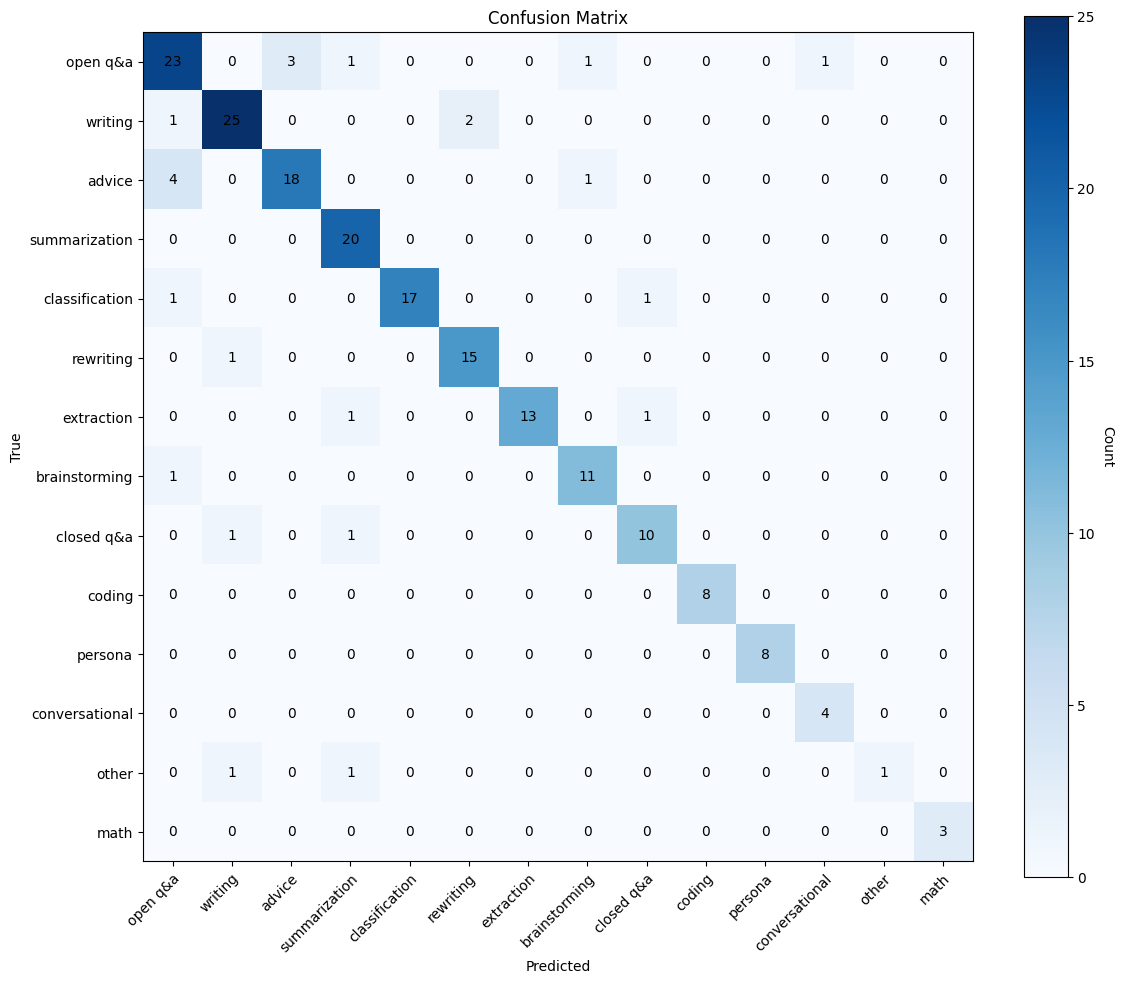

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your confusion matrix data
confusion_matrix = np.array([
    [23,  0,  3,  1,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0],
    [ 1, 25,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 4,  0, 18,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 1,  0,  0,  0, 17,  0,  0,  0,  1,  0,  0,  0,  0,  0],
    [ 0,  1,  0,  0,  0, 15,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  1,  0,  0, 13,  0,  1,  0,  0,  0,  0,  0],
    [ 1,  0,  0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0],
    [ 0,  1,  0,  1,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0],
    [ 0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3]
])

# Create labels
labels = ['open q&a', 'writing', 'advice', 'summarization', 'classification', 'rewriting', 'extraction', 'brainstorming', 'closed q&a', 'coding', 'persona', 'conversational', 'other', 'math']

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the heatmap
im = ax.imshow(confusion_matrix, cmap='Blues')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Set labels
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

# Loop over data dimensions and create text annotations
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, confusion_matrix[i, j],
                       ha="center", va="center", color="black")

# Create color bar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Count", rotation=-90, va="bottom")
# Set x-axis labels
ax.set_xticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")

# Set y-axis labels
ax.set_yticklabels(labels)
# Show the plot
plt.tight_layout()
# plt.show()

In [ ]:

import pandas as pd

data = {
    'Domain': [
        'open q&a', 'writing', 'advice', 'summarization', 'classification', 'rewriting',
        'extraction', 'brainstorming', 'closed q&a', 'coding', 'persona', 'conversational',
        'other', 'math'
    ],
    'Accuracy': [
        0.935, 0.97, 0.96, 0.98, 0.99, 0.985, 0.99, 0.985, 0.98, 1.0, 1.0, 0.995, 0.99, 1.0
    ],
    'Precision': [
        0.865686274509804, 0.9377076411960132, 0.9146049481245011, 0.9166666666666667,
        0.994535519125683, 0.9384442301510768, 0.9946524064171123, 0.9204031262854793,
        0.9113475177304965, 1.0, 1.0, 0.9, 0.9949748743718593, 1.0
    ],
    'Recall': [
        0.8760838878806211, 0.9377076411960132, 0.8828297715549005, 0.9888888888888889,
        0.9473684210526316, 0.9633152173913043, 0.9333333333333333, 0.9530141843971631,
        0.9113475177304965, 1.0, 1.0, 0.9974489795918368, 0.6666666666666666, 1.0
    ],
    'F1 Score': [
        0.8707689248968637, 0.9377076411960132, 0.8978549540347294, 0.9489274770173646,
        0.9694749694749695, 0.9504582610849641, 0.9615975422427036, 0.9359999999999999,
        0.9113475177304965, 1.0, 1.0, 0.9431656720659278, 0.7474747474747474, 1.0
    ],
    'AUC Score': [
        0.8760838878806211, 0.9377076411960132, 0.8828297715549005, 0.9888888888888888,
        0.9473684210526316, 0.9633152173913043, 0.9333333333333333, 0.9530141843971631,
        0.9113475177304966, 1.0, 1.0, 0.9974489795918368, 0.6666666666666666, 1.0
    ]
}

df = pd.DataFrame(data)
df

,Domain,Accuracy,Precision,Recall,F1 Score,AUC Score
0,open q&a,0.935,0.865686,0.876084,0.870769,0.876084
1,writing,0.970,0.937708,0.937708,0.937708,0.937708
2,advice,0.960,0.914605,0.882830,0.897855,0.882830
3,summarization,0.980,0.916667,0.988889,0.948927,0.988889
4,classification,0.990,0.994536,0.947368,0.969475,0.947368
5,rewriting,0.985,0.938444,0.963315,0.950458,0.963315
6,extraction,0.990,0.994652,0.933333,0.961598,0.933333
7,brainstorming,0.985,0.920403,0.953014,0.936000,0.953014
8,closed q&a,0.980,0.911348,0.911348,0.911348,0.911348
9,coding,1.000,1.000000,1.000000,1.000000,1.000000


('open q&a', 'conversational', 'advice', 'writing', 'coding', 'rewriting', 'closed q&a', 'brainstorming', 'extraction', 'summarization', 'math', 'persona', 'classification', 'help with given error', 'other', 'code modification', 'code testing', 'help understand given code')


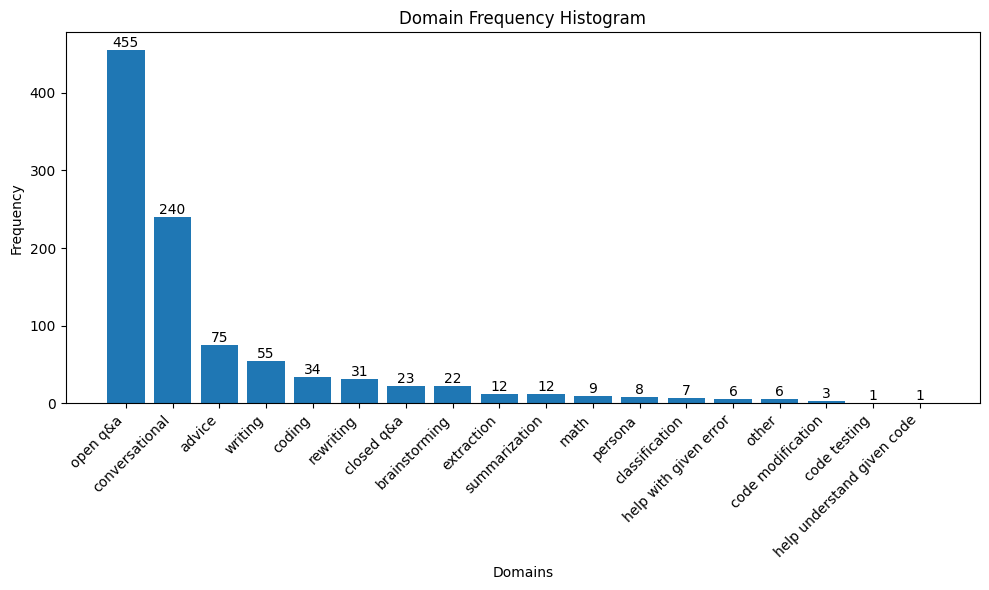

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Example list of domains

# Count the frequency of each domain
domain_counts = Counter(all_domains)

# Sort domains by frequency for better visualization
sorted_domains = sorted(domain_counts.items(), key=lambda x: x[1], reverse=True)
# Extract domains and their counts
domain_names, domain_frequencies = zip(*sorted_domains)
print(domain_names)
# Create the histogram
plt.figure(figsize=(10, 6))
bars = plt.bar(domain_names, domain_frequencies)

# Customize the chart
plt.title("Domain Frequency Histogram")
plt.xlabel("Domains")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()